In [1]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from tqdm import trange
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# https://github.com/samcw/ResNet18-Pytorch/blob/master/ResNet18.ipynb
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv1d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(outchannel)
            )
            
    def forward(self, x):
        # print(x.shape)
        out = self.left(x)
        # print(x.shape)
        out = out + self.shortcut(x)
        # print(x.shape)
        out = F.relu(out)
        # print(f"out of res block {x.shape}")
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(in_features=512, out_features=num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        ## print(x.shape)
        out = self.conv1(x)
        # print(x.shape)
        out = self.layer1(out)
        # print(x.shape)
        out = self.layer2(out)
        # print(x.shape)
        out = self.layer3(out)
        # print(x.shape)
        out = self.layer4(out)
        # print(x.shape)
        out = F.avg_pool1d(out, 4)
        # print(x.shape)
        out = out.view(out.size(0), -1)
        # print(f"here {x.shape}")
        out = self.fc(out)
        # print(f"here2 {x.shape}")
        return out

In [43]:
model = ResNet(ResidualBlock)
print(model)
x = torch.randn(64, 64,40)
output = model(x)
print(output.shape)

ResNet(
  (conv1): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (left): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (left): Sequential(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1,

RuntimeError: Given input size: (512x1x3). Calculated output size: (512x1x0). Output size is too small

In [3]:
class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
def importData():
    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
    for i in range(10):
        temp_train = np.load(f'../data/windtalker_steps/{i}_table_train.npy')
        temp_val = np.load(f'../data/windtalker_steps/{i}_table_val.npy')
        temp_test = np.load(f'../data/windtalker_steps/{i}_table_test.npy')
        if i == 0:
            X_train = temp_train
            X_val = temp_val
            X_test = temp_test
            y_train = np.array([[i] for _ in range(X_train.shape[0])])
            y_val = np.array([[i] for _ in range(X_val.shape[0])])
            y_test = np.array([[i] for _ in range(X_test.shape[0])])
        else:
            X_train = np.append(X_train, temp_train, axis=0)
            X_val = np.append(X_val, temp_val, axis=0)
            X_test = np.append(X_test, temp_test, axis=0)
            y_train = np.append(y_train, np.array([[i] for _ in range(temp_train.shape[0])]), axis=0)
            y_val = np.append(y_val, np.array([[i] for _ in range(temp_val.shape[0])]), axis=0)
            y_test = np.append(y_test, np.array([[i] for _ in range(temp_test.shape[0])]), axis=0)
            
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
class RunningAverage:
    def __init__(self):
        self.steps = 0
        self.total = 0

    def update(self, val):
        self.total += val
        self.steps += 1

    def __call__(self):
        return self.total / float(self.steps)

def accuracy(outputs, labels):
    # outputs (predicted), labels (true)
    outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
    labels = labels.squeeze()
    # compare outputs with labels
    return np.sum([1 if first == second else 0 for first, second in zip(labels, outputs)]) / float(len(labels))

In [6]:
def train(model, optimizer, trainLoader, loss_fn, iterations):
    model.train()
    train_loss = RunningAverage()
    train_acc = RunningAverage()
    
    with trange(iterations) as pbar:
        for X_batch, y_batch in trainLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            loss = loss_fn(logits, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.update(loss)
            train_acc.update(accuracy(y_pred, y_batch))
            pbar.update(1)
            
    return train_loss(), train_acc()
    
def eval(model, valLoader, loss_fn):
    model.eval()
    eval_loss = RunningAverage()
    eval_acc = RunningAverage()
    
    with torch.no_grad():
        for X_batch, y_batch in valLoader:
            y_batch = y_batch.type(torch.LongTensor).squeeze(1)
            logits = model(X_batch)
            y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
            
            loss = loss_fn(logits, y_batch)
            
            eval_loss.update(loss)
            eval_acc.update(accuracy(y_pred, y_batch))
            
    return eval_loss(), eval_acc()
    
def test(model, testLoader, test_size):
    model.eval()
    for X_batch, y_batch in testLoader:
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1) # use this for accuracy 
        
    print(f"Overall Accuracy: {accuracy(y_pred, y_batch):.3f}")

    # True positive percentage
    percentages = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
    # outputs (predicted), labels (true)
    outputs = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
    labels = y_batch.squeeze()
    
    for i in range(len(outputs)):
        if outputs[i] == labels[i]:
            percentages[outputs[i]] += 1
    
    # plot the percentages of correct predictions
    y_percent = [(value/(test_size/10))*100 for key, value in percentages.items()]
    x_label = [str(key) for key, _ in percentages.items()]
    
    fig, test = plt.subplots(figsize=(10,6))
    test.bar(x_label, y_percent)
    test.yaxis.set_major_formatter(mtick.PercentFormatter())
    
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Key")
    plt.title("Accuracy (%) per key")
    plt.savefig("percentage_correct_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()
    
    cm = confusion_matrix(y_true=labels, y_pred=outputs)
    cm = np.divide(cm, (test_size/10))
    
    plt.figure(figsize=(10,6))
    sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.savefig("confusion_matrix_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()
    
    print(f"Accuracy for each key: {''.join([x + ': ' + str(round(y, 3)) + '% ' for x, y in zip(x_label, y_percent)])}")
    
    print(classification_report(y_true=labels, y_pred=outputs, target_names=x_label))

In [7]:
def train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss_fn, iterations):
    # for plotting the loss and accuracy
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list  = [], [], [], []
        
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, trainLoader, loss_fn, iterations)
        eval_loss, eval_acc = eval(model, valLoader, loss_fn)
        
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        eval_loss_list.append(eval_loss)
        eval_acc_list.append(eval_acc)
        
        print(f"Train: Epoch {epoch}: Loss {train_loss}, Accuracy {train_acc}")
        print(f"Eval: Epoch {epoch}: Loss {eval_loss}, Accuracy {eval_acc}")
        
    return train_loss_list, train_acc_list, eval_loss_list, eval_acc_list
        

In [8]:
def plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs):
    x = [i for i in range(1, epochs+1)]
    
    fig, loss = plt.subplots(figsize=(10,6))
    loss.plot(x, [trainLoss.item() for trainLoss in train_loss_list], label="Training Loss")
    loss.plot(x, [evalLoss.item() for evalLoss in eval_loss_list], label="Validation Loss")
    plt.legend()
    plt.ylabel("Average Loss")
    plt.xlabel("Epochs")
    plt.title("Average Loss per epoch")
    plt.savefig("loss_per_epoch_denoised_butter_resnet.png", bbox_inches='tight')
    
    plt.show()
    
    fig, acc = plt.subplots(figsize=(10,6))
    acc.plot(x, [trainAcc.item() for trainAcc in train_acc_list], label="Training Accuracy")
    acc.plot(x, [evalAcc.item() for evalAcc in eval_acc_list], label="Validation Accuracy")
    plt.legend()
    plt.ylabel("Average Accuracy")
    plt.xlabel("Epochs")
    plt.title("Average Accuracy per epoch")
    plt.savefig("acc_per_epoch_denoised_butter_resnet.png", bbox_inches='tight')
    plt.show()

In [9]:
def print_model_parameters(model):
    total_parameters = 0
    print(" "*20 + "Model Parameters" + " "*20)
    print("="*57)
    print(f"{'Layer':<25}" + "| Parameters")
    print("="*57)
    for name, param in model.named_parameters():
        temp = 1
        temp_list = []
        if param.requires_grad:
            print(f"{name:<25}", end="")
            for i in param.data.shape:
                temp *= i
                temp_list.append(str(i))
            print(": ", end="")
            if len(temp_list) > 1:
                print(f"{' * '.join(temp_list)}", end="")
                print(" = " + str(temp))
            else:
                print(f"{''.join(temp_list)}")

        total_parameters += temp
        
    print("="*57)
    print(f"{'Total parameters':<25}" + f": {total_parameters}")
    print("="*57)

100%|██████████| 110/110 [00:13<00:00,  7.90it/s]


Train: Epoch 0: Loss 2.3567891120910645, Accuracy 0.09630681818181819
Eval: Epoch 0: Loss 2.3557538986206055, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.29it/s]


Train: Epoch 1: Loss 2.2381179332733154, Accuracy 0.17017045454545454
Eval: Epoch 1: Loss 2.3543810844421387, Accuracy 0.0947265625


100%|██████████| 110/110 [00:13<00:00,  8.32it/s]


Train: Epoch 2: Loss 2.1407675743103027, Accuracy 0.2767992424242424
Eval: Epoch 2: Loss 2.3558952808380127, Accuracy 0.0859375


100%|██████████| 110/110 [00:13<00:00,  8.21it/s]


Train: Epoch 3: Loss 2.0599708557128906, Accuracy 0.3609848484848485
Eval: Epoch 3: Loss 2.3526690006256104, Accuracy 0.0986328125


100%|██████████| 110/110 [00:13<00:00,  8.12it/s]


Train: Epoch 4: Loss 1.9712278842926025, Accuracy 0.46505681818181815
Eval: Epoch 4: Loss 2.3673572540283203, Accuracy 0.0986328125


100%|██████████| 110/110 [00:13<00:00,  8.12it/s]


Train: Epoch 5: Loss 1.8853132724761963, Accuracy 0.531439393939394
Eval: Epoch 5: Loss 2.377319574356079, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.03it/s]


Train: Epoch 6: Loss 1.7882145643234253, Accuracy 0.6078598484848484
Eval: Epoch 6: Loss 2.394649028778076, Accuracy 0.1015625


100%|██████████| 110/110 [00:14<00:00,  7.48it/s]


Train: Epoch 7: Loss 1.6684458255767822, Accuracy 0.6767992424242425
Eval: Epoch 7: Loss 2.406388759613037, Accuracy 0.0986328125


100%|██████████| 110/110 [00:14<00:00,  7.37it/s]


Train: Epoch 8: Loss 1.5532941818237305, Accuracy 0.7238636363636364
Eval: Epoch 8: Loss 2.439298152923584, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  7.99it/s]


Train: Epoch 9: Loss 1.4270446300506592, Accuracy 0.7682765151515152
Eval: Epoch 9: Loss 2.473008632659912, Accuracy 0.091796875


100%|██████████| 110/110 [00:14<00:00,  7.63it/s]


Train: Epoch 10: Loss 1.288852572441101, Accuracy 0.8142992424242425
Eval: Epoch 10: Loss 2.4984021186828613, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  7.92it/s]


Train: Epoch 11: Loss 1.1414515972137451, Accuracy 0.8517992424242424
Eval: Epoch 11: Loss 2.542854070663452, Accuracy 0.0908203125


100%|██████████| 110/110 [00:13<00:00,  8.03it/s]


Train: Epoch 12: Loss 1.0005394220352173, Accuracy 0.8864583333333333
Eval: Epoch 12: Loss 2.598219633102417, Accuracy 0.0986328125


100%|██████████| 110/110 [00:15<00:00,  6.93it/s]


Train: Epoch 13: Loss 0.8639631867408752, Accuracy 0.9089962121212121
Eval: Epoch 13: Loss 2.6489410400390625, Accuracy 0.09765625


100%|██████████| 110/110 [00:16<00:00,  6.58it/s]


Train: Epoch 14: Loss 0.7122802734375, Accuracy 0.9347537878787879
Eval: Epoch 14: Loss 2.7205896377563477, Accuracy 0.09765625


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


Train: Epoch 15: Loss 0.5931787490844727, Accuracy 0.9512310606060607
Eval: Epoch 15: Loss 2.761014699935913, Accuracy 0.091796875


100%|██████████| 110/110 [00:15<00:00,  6.98it/s]


Train: Epoch 16: Loss 0.49191543459892273, Accuracy 0.9715909090909091
Eval: Epoch 16: Loss 2.8266184329986572, Accuracy 0.0986328125


100%|██████████| 110/110 [00:14<00:00,  7.42it/s]


Train: Epoch 17: Loss 0.4094643294811249, Accuracy 0.9789772727272728
Eval: Epoch 17: Loss 2.8958635330200195, Accuracy 0.1025390625


100%|██████████| 110/110 [00:15<00:00,  6.91it/s]


Train: Epoch 18: Loss 0.3198305368423462, Accuracy 0.9881628787878788
Eval: Epoch 18: Loss 2.958092212677002, Accuracy 0.1123046875


100%|██████████| 110/110 [00:15<00:00,  7.20it/s]


Train: Epoch 19: Loss 0.2747732400894165, Accuracy 0.9929924242424243
Eval: Epoch 19: Loss 3.0050809383392334, Accuracy 0.09375


100%|██████████| 110/110 [00:15<00:00,  7.17it/s]


Train: Epoch 20: Loss 0.22070428729057312, Accuracy 0.9932765151515152
Eval: Epoch 20: Loss 3.066128969192505, Accuracy 0.1015625


100%|██████████| 110/110 [00:16<00:00,  6.82it/s]


Train: Epoch 21: Loss 0.1720270812511444, Accuracy 0.9980113636363637
Eval: Epoch 21: Loss 3.129105806350708, Accuracy 0.099609375


100%|██████████| 110/110 [00:15<00:00,  7.16it/s]


Train: Epoch 22: Loss 0.1643790751695633, Accuracy 0.9957386363636364
Eval: Epoch 22: Loss 3.160994052886963, Accuracy 0.103515625


100%|██████████| 110/110 [00:15<00:00,  7.32it/s]


Train: Epoch 23: Loss 0.13265234231948853, Accuracy 0.9985795454545454
Eval: Epoch 23: Loss 3.2247374057769775, Accuracy 0.0927734375


100%|██████████| 110/110 [00:14<00:00,  7.45it/s]


Train: Epoch 24: Loss 0.11032847315073013, Accuracy 0.9982954545454545
Eval: Epoch 24: Loss 3.2371973991394043, Accuracy 0.1015625


100%|██████████| 110/110 [00:16<00:00,  6.67it/s]


Train: Epoch 25: Loss 0.1061011254787445, Accuracy 0.9982954545454545
Eval: Epoch 25: Loss 3.288296699523926, Accuracy 0.1025390625


100%|██████████| 110/110 [00:16<00:00,  6.80it/s]


Train: Epoch 26: Loss 0.08097825199365616, Accuracy 0.9997159090909091
Eval: Epoch 26: Loss 3.3347156047821045, Accuracy 0.1015625


100%|██████████| 110/110 [00:15<00:00,  7.14it/s]


Train: Epoch 27: Loss 0.07476838678121567, Accuracy 0.9985795454545454
Eval: Epoch 27: Loss 3.3378868103027344, Accuracy 0.10546875


100%|██████████| 110/110 [00:15<00:00,  7.20it/s]


Train: Epoch 28: Loss 0.06834415346384048, Accuracy 0.9997159090909091
Eval: Epoch 28: Loss 3.3667709827423096, Accuracy 0.1025390625


100%|██████████| 110/110 [00:16<00:00,  6.61it/s]


Train: Epoch 29: Loss 0.06104118004441261, Accuracy 0.9994318181818181
Eval: Epoch 29: Loss 3.4065542221069336, Accuracy 0.10546875


100%|██████████| 110/110 [00:15<00:00,  7.17it/s]


Train: Epoch 30: Loss 0.06159380078315735, Accuracy 0.9985795454545454
Eval: Epoch 30: Loss 3.4481241703033447, Accuracy 0.0947265625


100%|██████████| 110/110 [00:15<00:00,  7.10it/s]


Train: Epoch 31: Loss 0.049591436982154846, Accuracy 0.9991477272727273
Eval: Epoch 31: Loss 3.483070135116577, Accuracy 0.095703125


100%|██████████| 110/110 [00:14<00:00,  7.35it/s]


Train: Epoch 32: Loss 0.04456940293312073, Accuracy 1.0
Eval: Epoch 32: Loss 3.4989194869995117, Accuracy 0.09765625


100%|██████████| 110/110 [00:14<00:00,  7.66it/s]


Train: Epoch 33: Loss 0.043908312916755676, Accuracy 0.9997159090909091
Eval: Epoch 33: Loss 3.523075819015503, Accuracy 0.1044921875


100%|██████████| 110/110 [00:14<00:00,  7.74it/s]


Train: Epoch 34: Loss 0.037622950971126556, Accuracy 1.0
Eval: Epoch 34: Loss 3.5510752201080322, Accuracy 0.095703125


100%|██████████| 110/110 [00:14<00:00,  7.40it/s]


Train: Epoch 35: Loss 0.03560984507203102, Accuracy 0.9991477272727273
Eval: Epoch 35: Loss 3.5574629306793213, Accuracy 0.1025390625


100%|██████████| 110/110 [00:14<00:00,  7.50it/s]


Train: Epoch 36: Loss 0.031974565237760544, Accuracy 0.9994318181818181
Eval: Epoch 36: Loss 3.593432903289795, Accuracy 0.0966796875


100%|██████████| 110/110 [00:14<00:00,  7.82it/s]


Train: Epoch 37: Loss 0.028879549354314804, Accuracy 1.0
Eval: Epoch 37: Loss 3.6281580924987793, Accuracy 0.095703125


100%|██████████| 110/110 [00:13<00:00,  7.95it/s]


Train: Epoch 38: Loss 0.026887936517596245, Accuracy 1.0
Eval: Epoch 38: Loss 3.6399037837982178, Accuracy 0.099609375


100%|██████████| 110/110 [00:14<00:00,  7.57it/s]


Train: Epoch 39: Loss 0.02572932094335556, Accuracy 0.9988636363636364
Eval: Epoch 39: Loss 3.670412063598633, Accuracy 0.1025390625


100%|██████████| 110/110 [00:13<00:00,  8.06it/s]


Train: Epoch 40: Loss 0.031555257737636566, Accuracy 0.9991477272727273
Eval: Epoch 40: Loss 3.6873579025268555, Accuracy 0.091796875


100%|██████████| 110/110 [00:13<00:00,  7.91it/s]


Train: Epoch 41: Loss 0.026383107528090477, Accuracy 0.9991477272727273
Eval: Epoch 41: Loss 3.658301591873169, Accuracy 0.09375


100%|██████████| 110/110 [00:16<00:00,  6.61it/s]


Train: Epoch 42: Loss 0.022635001689195633, Accuracy 0.9997159090909091
Eval: Epoch 42: Loss 3.7195346355438232, Accuracy 0.099609375


100%|██████████| 110/110 [00:15<00:00,  6.92it/s]


Train: Epoch 43: Loss 0.019862554967403412, Accuracy 1.0
Eval: Epoch 43: Loss 3.7020957469940186, Accuracy 0.0947265625


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


Train: Epoch 44: Loss 0.01622934825718403, Accuracy 1.0
Eval: Epoch 44: Loss 3.7418434619903564, Accuracy 0.0947265625


100%|██████████| 110/110 [00:14<00:00,  7.39it/s]


Train: Epoch 45: Loss 0.015623322688043118, Accuracy 1.0
Eval: Epoch 45: Loss 3.7300074100494385, Accuracy 0.1005859375


100%|██████████| 110/110 [00:14<00:00,  7.67it/s]


Train: Epoch 46: Loss 0.015406036749482155, Accuracy 1.0
Eval: Epoch 46: Loss 3.781977415084839, Accuracy 0.1005859375


100%|██████████| 110/110 [00:14<00:00,  7.56it/s]


Train: Epoch 47: Loss 0.014993634074926376, Accuracy 0.9997159090909091
Eval: Epoch 47: Loss 3.799668073654175, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.04it/s]


Train: Epoch 48: Loss 0.01357229333370924, Accuracy 0.9997159090909091
Eval: Epoch 48: Loss 3.8049476146698, Accuracy 0.09375


100%|██████████| 110/110 [00:13<00:00,  8.04it/s]


Train: Epoch 49: Loss 0.014590662904083729, Accuracy 0.9994318181818181
Eval: Epoch 49: Loss 3.841132164001465, Accuracy 0.09375


100%|██████████| 110/110 [00:13<00:00,  8.06it/s]


Train: Epoch 50: Loss 0.011272137053310871, Accuracy 1.0
Eval: Epoch 50: Loss 3.8452112674713135, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.06it/s]


Train: Epoch 51: Loss 0.012443316169083118, Accuracy 0.9994318181818181
Eval: Epoch 51: Loss 3.838313102722168, Accuracy 0.095703125


100%|██████████| 110/110 [00:13<00:00,  7.89it/s]


Train: Epoch 52: Loss 0.014354811981320381, Accuracy 0.9994318181818181
Eval: Epoch 52: Loss 3.9027323722839355, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.08it/s]


Train: Epoch 53: Loss 0.02161865495145321, Accuracy 0.9964962121212121
Eval: Epoch 53: Loss 3.908884286880493, Accuracy 0.1044921875


100%|██████████| 110/110 [00:13<00:00,  8.00it/s]


Train: Epoch 54: Loss 0.01479156780987978, Accuracy 0.9994318181818181
Eval: Epoch 54: Loss 3.918544054031372, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  8.02it/s]


Train: Epoch 55: Loss 0.01047963835299015, Accuracy 1.0
Eval: Epoch 55: Loss 3.957580089569092, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.07it/s]


Train: Epoch 56: Loss 0.012031381949782372, Accuracy 0.9997159090909091
Eval: Epoch 56: Loss 3.965245485305786, Accuracy 0.0927734375


100%|██████████| 110/110 [00:13<00:00,  7.97it/s]


Train: Epoch 57: Loss 0.010300379246473312, Accuracy 1.0
Eval: Epoch 57: Loss 3.9685182571411133, Accuracy 0.1064453125


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 58: Loss 0.011433469131588936, Accuracy 0.9991477272727273
Eval: Epoch 58: Loss 3.987496852874756, Accuracy 0.0927734375


100%|██████████| 110/110 [00:13<00:00,  7.86it/s]


Train: Epoch 59: Loss 0.010974121280014515, Accuracy 0.9997159090909091
Eval: Epoch 59: Loss 4.025745391845703, Accuracy 0.0908203125


100%|██████████| 110/110 [00:13<00:00,  7.98it/s]


Train: Epoch 60: Loss 0.010864416137337685, Accuracy 0.9991477272727273
Eval: Epoch 60: Loss 4.03817892074585, Accuracy 0.1064453125


100%|██████████| 110/110 [00:13<00:00,  7.99it/s]


Train: Epoch 61: Loss 0.007994969375431538, Accuracy 1.0
Eval: Epoch 61: Loss 4.062617778778076, Accuracy 0.09765625


100%|██████████| 110/110 [00:13<00:00,  7.99it/s]


Train: Epoch 62: Loss 0.006460010539740324, Accuracy 1.0
Eval: Epoch 62: Loss 4.060830593109131, Accuracy 0.1044921875


100%|██████████| 110/110 [00:13<00:00,  8.03it/s]


Train: Epoch 63: Loss 0.0068179527297616005, Accuracy 0.9997159090909091
Eval: Epoch 63: Loss 4.055661201477051, Accuracy 0.1064453125


100%|██████████| 110/110 [00:14<00:00,  7.80it/s]


Train: Epoch 64: Loss 0.006532595958560705, Accuracy 1.0
Eval: Epoch 64: Loss 4.061809062957764, Accuracy 0.1015625


100%|██████████| 110/110 [00:13<00:00,  8.02it/s]


Train: Epoch 65: Loss 0.005512116942554712, Accuracy 1.0
Eval: Epoch 65: Loss 4.051459312438965, Accuracy 0.10546875


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 66: Loss 0.006974487565457821, Accuracy 0.9992424242424243
Eval: Epoch 66: Loss 4.037981986999512, Accuracy 0.0986328125


100%|██████████| 110/110 [00:13<00:00,  7.94it/s]


Train: Epoch 67: Loss 0.008096964098513126, Accuracy 0.9997159090909091
Eval: Epoch 67: Loss 4.135724067687988, Accuracy 0.099609375


100%|██████████| 110/110 [00:13<00:00,  7.96it/s]


Train: Epoch 68: Loss 0.007201136089861393, Accuracy 0.9994318181818181
Eval: Epoch 68: Loss 4.151024341583252, Accuracy 0.0908203125


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 69: Loss 0.005988115444779396, Accuracy 1.0
Eval: Epoch 69: Loss 4.160060405731201, Accuracy 0.091796875


100%|██████████| 110/110 [00:13<00:00,  8.03it/s]


Train: Epoch 70: Loss 0.00586423696950078, Accuracy 1.0
Eval: Epoch 70: Loss 4.149928092956543, Accuracy 0.091796875


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 71: Loss 0.008683104068040848, Accuracy 0.9982007575757575
Eval: Epoch 71: Loss 4.162744998931885, Accuracy 0.0927734375


100%|██████████| 110/110 [00:13<00:00,  7.96it/s]


Train: Epoch 72: Loss 0.008471774868667126, Accuracy 0.9997159090909091
Eval: Epoch 72: Loss 4.1471781730651855, Accuracy 0.0888671875


100%|██████████| 110/110 [00:13<00:00,  8.03it/s]


Train: Epoch 73: Loss 0.0062448144890367985, Accuracy 0.9992424242424243
Eval: Epoch 73: Loss 4.123724460601807, Accuracy 0.0966796875


100%|██████████| 110/110 [00:13<00:00,  8.00it/s]


Train: Epoch 74: Loss 0.00719852838665247, Accuracy 0.9992424242424243
Eval: Epoch 74: Loss 4.192788124084473, Accuracy 0.0947265625


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 75: Loss 0.010517301969230175, Accuracy 0.9969696969696971
Eval: Epoch 75: Loss 4.258709907531738, Accuracy 0.0986328125


100%|██████████| 110/110 [00:13<00:00,  8.01it/s]


Train: Epoch 76: Loss 0.010819794610142708, Accuracy 0.9997159090909091
Eval: Epoch 76: Loss 4.246765613555908, Accuracy 0.09765625


100%|██████████| 110/110 [00:13<00:00,  7.97it/s]


Train: Epoch 77: Loss 0.005926346872001886, Accuracy 1.0
Eval: Epoch 77: Loss 4.232832431793213, Accuracy 0.1025390625


100%|██████████| 110/110 [00:13<00:00,  8.05it/s]


Train: Epoch 78: Loss 0.0050625004805624485, Accuracy 1.0
Eval: Epoch 78: Loss 4.2381086349487305, Accuracy 0.09765625


100%|██████████| 110/110 [00:13<00:00,  7.99it/s]


Train: Epoch 79: Loss 0.004656685516238213, Accuracy 1.0
Eval: Epoch 79: Loss 4.25333833694458, Accuracy 0.09765625


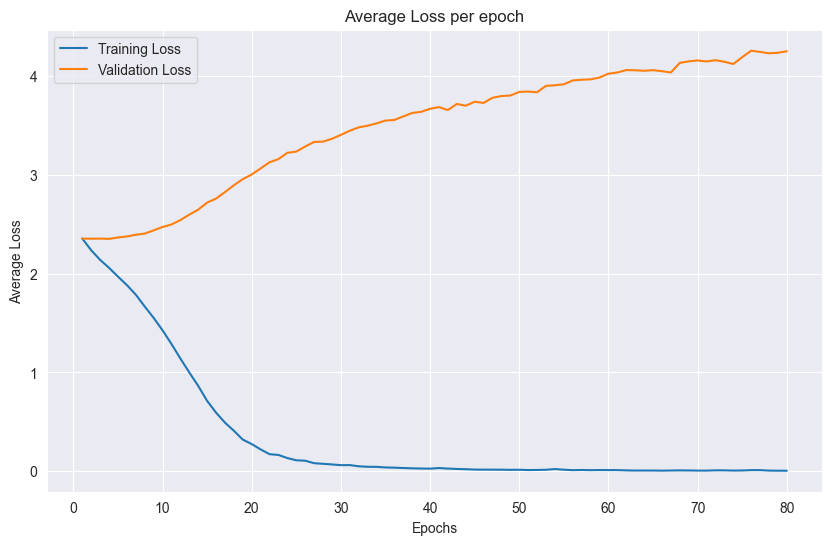

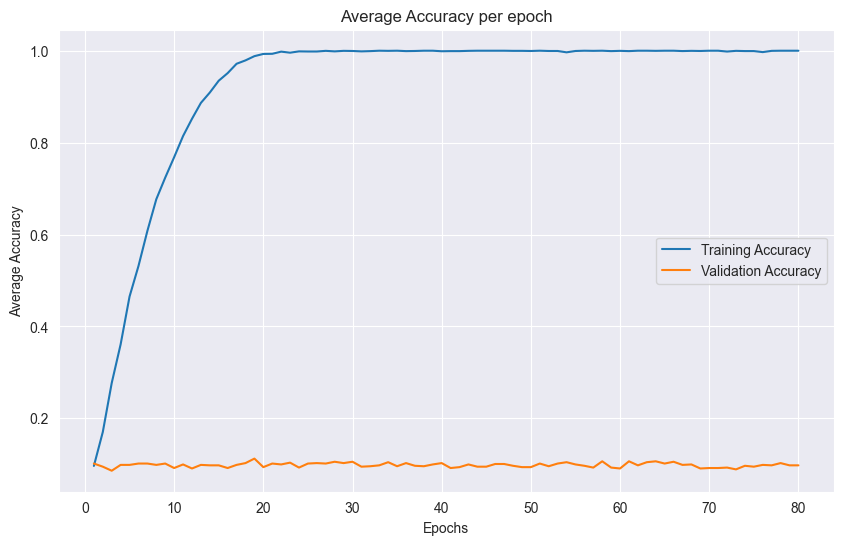

Overall Accuracy: 0.100


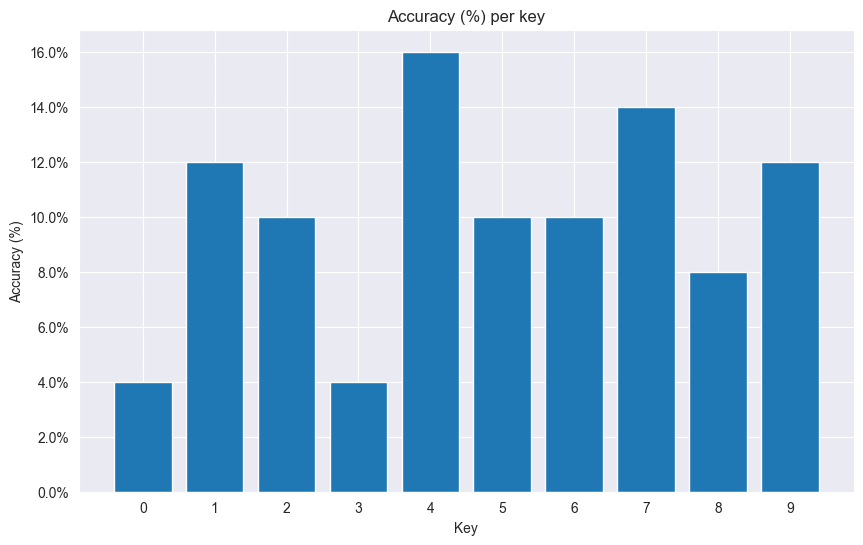

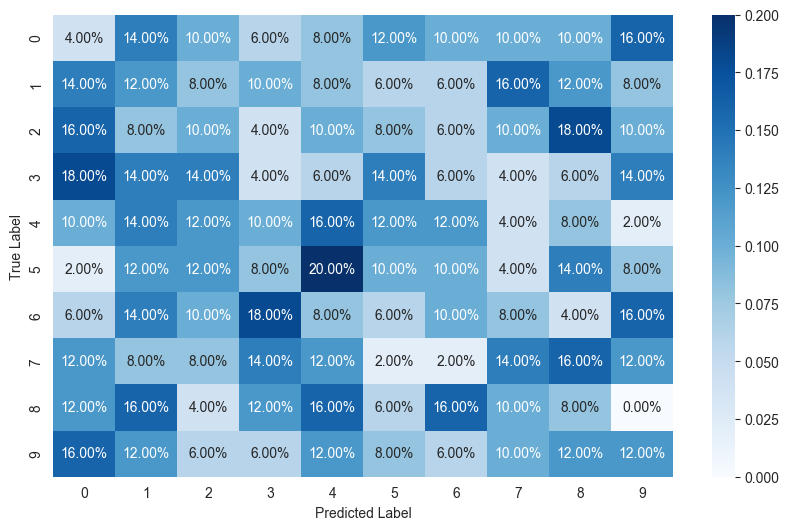

Accuracy for each key: 0: 4.0% 1: 12.0% 2: 10.0% 3: 4.0% 4: 16.0% 5: 10.0% 6: 10.0% 7: 14.0% 8: 8.0% 9: 12.0% 
              precision    recall  f1-score   support

           0       0.04      0.04      0.04        50
           1       0.10      0.12      0.11        50
           2       0.11      0.10      0.10        50
           3       0.04      0.04      0.04        50
           4       0.14      0.16      0.15        50
           5       0.12      0.10      0.11        50
           6       0.12      0.10      0.11        50
           7       0.16      0.14      0.15        50
           8       0.07      0.08      0.08        50
           9       0.12      0.12      0.12        50

    accuracy                           0.10       500
   macro avg       0.10      0.10      0.10       500
weighted avg       0.10      0.10      0.10       500

                    Model Parameters                    
Layer                    | Parameters
conv1.0.weight           : 64 * 4 *

In [14]:
def main():
    # setup parameters and load data
    batch_size = 32
    epochs = 80
    number_of_categories = 10
    
    X_train, X_val, X_test, y_train, y_val, y_test = importData()
    trainDataset = CSIDataset(X_train, y_train)
    valDataset = CSIDataset(X_val, y_val)
    
    trainLoader = DataLoader(trainDataset, shuffle=True, batch_size=batch_size)
    valLoader = DataLoader(valDataset, shuffle=True, batch_size=batch_size)

    model = ResNet(ResidualBlock)
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    loss = nn.CrossEntropyLoss()

    # if (os.path.isfile("model.pth")):
    #     model.load_state_dict(torch.load('model.pth'))
    # else:
    #     train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    #     # save the model
    #     torch.save(model.state_dict(), 'model.pth')
    #     plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
        
    train_loss_list, train_acc_list, eval_loss_list, eval_acc_list = train_and_eval(model, epochs, optimizer, trainLoader, valLoader, loss, (X_train.shape[0]//batch_size) + 1)
    plot_loss_accuracy(train_loss_list, train_acc_list, eval_loss_list, eval_acc_list, epochs)
    torch.save(model.state_dict(), 'model_denoised_butter.pth')
    
    # Simple check with test dataset
    model.eval()
    testDataset = CSIDataset(X_test, y_test)
    testLoader = DataLoader(testDataset, shuffle=True, batch_size=X_test.shape[0])
    test(model, testLoader, X_test.shape[0])
    
    print_model_parameters(model)
    
main()

In [71]:
number_of_categories = 10
model = ResNet1D(64, 64, 3, 1, 1, 10, number_of_categories)
model.load_state_dict(torch.load('model_denoised_butter.pth'))
model.eval()

k = 3
extension = ".npy"
for file in os.listdir("../data/real_env"):
    if file.endswith(extension):
        print("========" + file + "========")
        y_batch = torch.tensor([[int(i)] for i in file.split("_")[0]], dtype=torch.float32)
        X_batch = torch.tensor(np.load("../data/real_env_denoised_butter/" + file), dtype=torch.float32)
        
        y_batch = y_batch.type(torch.LongTensor).squeeze(1)
        logits = model(X_batch)
        y_pred = F.log_softmax(logits, dim=1)
        
        predicted = np.argmax(y_pred.cpu().detach().numpy(), axis=1)
        print(f"Actual: " + f"{y_batch.tolist()}" + " Predicted: " f"{predicted}")
        values, indices = y_pred.topk(k)
        transposed_indx = torch.transpose(indices, 0, 1)
        print(f"Top k predictions: \n{transposed_indx.tolist()}")

========1436_table.npy========
Actual: [1, 4, 3, 6] Predicted: [2 2 9 0]
Top k predictions: 
[[2, 2, 9, 0], [3, 3, 3, 9], [8, 0, 0, 6]]
========1458_table.npy========
Actual: [1, 4, 5, 8] Predicted: [0 0 0 0]
Top k predictions: 
[[0, 0, 0, 0], [6, 9, 6, 9], [9, 6, 9, 6]]
========1524_table.npy========
Actual: [1, 5, 2, 4] Predicted: [4 4 4 4]
Top k predictions: 
[[4, 4, 4, 4], [1, 6, 6, 6], [6, 1, 1, 1]]
========2289_table.npy========
Actual: [2, 2, 8, 9] Predicted: [9 5 2 9]
Top k predictions: 
[[9, 5, 2, 9], [5, 9, 3, 0], [0, 8, 8, 5]]
========2379_table.npy========
Actual: [2, 3, 7, 9] Predicted: [4 4 4 4]
Top k predictions: 
[[4, 4, 4, 4], [1, 1, 1, 2], [7, 6, 7, 1]]
========3371_table.npy========
Actual: [3, 3, 7, 1] Predicted: [0 0 0 9]
Top k predictions: 
[[0, 0, 0, 9], [9, 9, 6, 0], [6, 6, 2, 5]]
========3917_table.npy========
Actual: [3, 9, 1, 7] Predicted: [2 2 4 4]
Top k predictions: 
[[2, 2, 4, 4], [4, 4, 2, 1], [1, 1, 1, 2]]
========4477_table.npy========
Actual: [4, 4, 7,